# Running queries across time

As we have seen in the ingestion tutorial, functions can be submitted to a graph and a dataframe returned. However, this is just scratching the surface of what is possible in Raphtory. In this tutorial we will go through all of the different ways the graph and its history can be manipulated to produce exciting new insights about your data.

## Time API Overview

When running queries in Raphtory we have five steps which may be undertaken depending on your desired output, all of which we will cover in this tutorial. In order of execution these are: 

1. Filtering the timeline to the segment you are interested in. All updates/history outside of this will be ignored.

2. Choosing a point, or set of points in time at which to view the graph. 

3. Choosing which direction (`past` or `future`) to look in at these points or apply a set of windows. This along with point 2 creates our `Perspectives`.

4. Apply a sequence of graph operations/algorithms that end with a `select()`. Followed by a sequence of table operations to get a result for your query.

5. Finally, either write your result to a `sink`, saving it for later processing, or return it as a dataframe to be used straightaway. 

Stages 1-4 are `lazy` operations, meaning computation inside Raphtory is only kicked off once you have chosen an output format in step 5. A conceptual example of the stages for creating perspectives from a temporal graph is depicted below.

<p align="center">
	<img src="../images/query-stages.png" width="60%" alt="Stages of queries"/>
</p>

To dig into this, let's quickly spin up a graph. This is exactly the same as the ones we have been using in the prior tutorial.

In [1]:
from pyraphtory.algorithm import PyAlgorithm
from pyraphtory.graph import TemporalGraph, Row, Table
from pyraphtory.graph import Row
from pyraphtory.vertex import Vertex
import csv
from pyraphtory.context import PyRaphtory
from pyraphtory.graph import Row
from pyraphtory.algorithm import Alignment
from pyraphtory.sinks import FileSink
from pyraphtory.formats import JsonFormat
from matplotlib import pyplot as plt

structure_file = "/tmp/lotr.csv"
ctx = PyRaphtory.local()

lotr_graph = ctx.new_graph()
with open(structure_file, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:
        source_node = row[0]
        destination_node = row[1]
        timestamp = int(row[2])
        lotr_graph.add_vertex(timestamp, source_node, vertex_type="Character")
        lotr_graph.add_vertex(timestamp, destination_node, vertex_type="Character")  
        lotr_graph.add_edge(timestamp, source_node, destination_node, edge_type="Character_Co-occurence")

##   Simplest Raphtory Query
While there may be many cases where all of the defined stages are needed, in the simplest case we may just want to run an algorithm on the latest version of our graph. For this we can call the `execute()` function directly on the graph, followed by `to_df()` to get the output. In this case, Raphtory runs the given algorithm using all the information it has about the graph, from the earliest to the latest update.

You can see in the cell below that our returned dataframe has a __timestamp__ at 32674, our last sentence in the Lord of the rings data. 

**Note:** What is happening in this `Degree` algorithm is specified in the `algorithm documentation` which you can see in the Table of Contents on the left hand side of this page. Every algorithm described there may be used in the same way, so feel free to experiment. We will look into these more later in the tutorial.

Using this basic query as our base, let's investigate the other layers.

In [2]:
lotr_graph \
    .execute(ctx.algorithms.generic.centrality.Degree()) \
    .to_df(["name","inDegree","outdegree","degree"])

,timestamp,name,inDegree,outdegree,degree
0,32674,Hirgon,0,2,2
1,32674,Hador,2,1,3
2,32674,Horn,3,1,4
3,32674,Galadriel,16,6,19
4,32674,Isildur,0,18,18
...,...,...,...,...,...
134,32674,Faramir,29,3,29
135,32674,Bain,1,1,2
136,32674,Walda,10,3,13
137,32674,Thranduil,2,0,2



## Timeline filtering

Going back to stage 1 we can filter the data to a particular time range, removing any updates which occurred outside of this period. Note, this only happens for the query and has no affect on the underlying data! 

For example, let's say that you want to see the relationships between characters before sentence 1000 or between sentences 4000 and 5000. We need two different versions of the graph, which can be seen in the code block below. Here, `first_1000_sentences` holds all the interactions before sentence 1000 and `sentences_from_4000_to_5000` holds all the interactions between sentence 4000 (included) and 5000 (excluded). When we print the dataframe we can see that the timestamp these run at is the latest available within their filtered timeline.

In addition to `until` and `slice`, you have access to two more methods: `starting_from` and `to`. The table below provides a quick summary:

| Function              | Activity kept                          |
|-----------------------|----------------------------------------|
| `starting_from(start)`| everything after `start` (inclusive)   |
| `until(end)`          | everything before `end` (exclusive)    |
| `to(end)`             | everything before `end` (inclusive)    |
| `slice(start, end)`   | equivalent to `from(start).until(end)` |

In [3]:
first_1000_sentences      = lotr_graph.until(1000)
sentences_from_4000_to_5000 = lotr_graph.slice(4000, 5000)


first_1000_df= first_1000_sentences \
    .execute(ctx.algorithms.generic.centrality.Degree()) \
    .to_df(["name","inDegree","outdegree","degree"])

from_4000_to_5000_df= sentences_from_4000_to_5000 \
    .execute(ctx.algorithms.generic.centrality.Degree()) \
    .to_df(["name","inDegree","outdegree","degree"])

print("First 1000 sentences")
print(first_1000_df.head(3),"\n") 
print("Between Sentences 4000 and 5000")
print(from_4000_to_5000_df.head(3))

First 1000 sentences
   timestamp      name  inDegree  outdegree  degree
0        999     Frodo         1          4       5
1        999  Meriadoc         0          1       1
2        999    Elrond         2          0       2 

Between Sentences 4000 and 5000
   timestamp    name  inDegree  outdegree  degree
0       4999  Pippin         0          5       5
1       4999   Frodo         2          4       5
2       4999   Merry         3          0       3


## Creating perspectives

Moving into our second stage, so far we have only executed algorithms over singular perspectives of the graph without defining any parameters. However, Raphtory can run algorithms over sequences of perspectives to explore how the output metrics evolve.

The process to create perspectives has two steps. The first of these is setting the times you are interested in, which can be a singular point (using `at()`) or, alternatively, a sequence of points with a given increment. For sequences, four different methods are available:

| Function                   | Effect                                     |
|----------------------------|--------------------------------------------|
| `walk(increment)`          | Set only the increment                     |
| `depart(time,increment)`   | Set the start time and increment           |
| `climb(time,increment)`    | Set the end time and increment             |
| `range(start,end,increment`| Set the start time, end time and increment |

For the functions other than `range()` where the start and end time may not be provided, Raphtory will default to the minimum and maximum times in the data/the timerange if a `slice()` etc. has been applied.

Once your timepoints are defined the second step is to specify which direction you are looking in at each timepoint. For this we have three options:
* We can look into the `past`, which will include everything that has happened before the timepoint.
* We can look into the `future`, including everything which has yet to happen from the timepoint.
* We can set a `window`, to look a specific amount in either direction. 

We will cover windows in a second as they have several options worth mentioning. For now lets take our basic query and `walk` it across the full timeline with increments of 1000 sentences, looking into the past and future to see the difference. 

In the below code cell we first create a matplotlib figure and a function which will take the output from our queries, sum up the out degree (co-occurrences) per timestamp and plot this. 

Next we create two queries where the only difference is the call to `past()` and `future()`. Looking at the plot these produce opposing results. This is because `df_past` is effectively counting how many unique character interactions have happened at each point, and `df_future` is counting how many are remaining.  

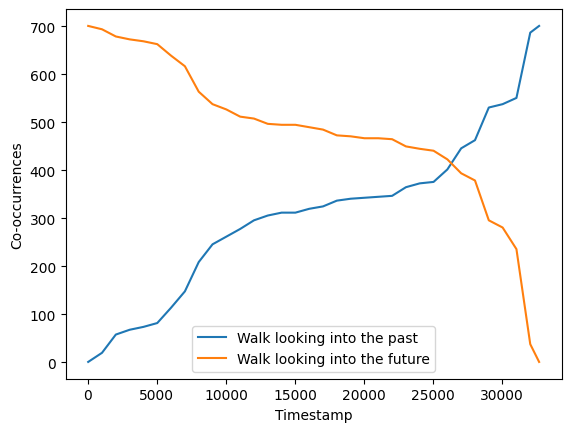

In [4]:
#Create a figure for us to plot on
fig,ax = plt.subplots()
ax.set_xlabel("Timestamp")
ax.set_ylabel("Co-occurrences") 

#Create a function which takes a dataframe from our query, sums up the outdegree seen per timestamp and plots it 
def group_outdegree_and_plot(df,ax,label):
    df_grouped = df.groupby('timestamp').sum('outdegree').reset_index()
    ax.plot(df_grouped['timestamp'],df_grouped['outdegree'],label=label)


#Start at the earliest time and run the query at every 1000 increments up until the latest time, looking into the past
df_past =lotr_graph \
    .walk(1000)\
    .past() \
    .execute(ctx.algorithms.generic.centrality.Degree()) \
    .to_df(["name","inDegree","outdegree","degree"]) 

#Start at the earliest time and run the query at every 1000 increments up until the latest time, looking into the future
df_future =lotr_graph \
    .walk(1000)\
    .future() \
    .execute(ctx.algorithms.generic.centrality.Degree()) \
    .to_df(["name","inDegree","outdegree","degree"]) 

#submit our two dataframes for plotting
group_outdegree_and_plot(df_past,ax,"Walk looking into the past")
group_outdegree_and_plot(df_future,ax,"Walk looking into the future")   
ax.legend()   


## Using Windows

Now that we understand the direction of the perspective, let's have a look at windows. Windows operate similarly to a timeline filter in that anything outside of the window is removed from the perspective. We can align windowed perspectives to specify where the timepoint refers to. This can be: 

* The `End` of the window - meaning we are looking into the past a set amount of time. This is the default.
* The `Start` of the window - meaning we are looking into the future a set amount of time. 
* The `Middle` of the window - including data from half the time in both the past and future, providing a smoothing effect.

In addition to the alignment, we can specify any number of windows which will run in a batch, allowing us to explore what is happening in the short and long term within the data. Let's run a set of windows along with some of the other functions introduced above.

In the cell below we:

* First create a new figure and a set of windows, increasing by order of magnitude between 100 and 100,000. 
* We then create our query and apply two timeline filters, removing anything before line 5000 and after line 20000.
* Next we set a `range()` which is quite similar to that of the walk we executed above, but we are now explicitly setting the start and end as our timeline filters would otherwise bound these.
* Finally we apply our windows, setting the alignment to the `end()` i.e. looking into the past. This is the default, but is present to show what it would look like if you wanted to use one of the other options.

For each window we filter the results and group the out degree per timestamp, plotting to our figure. The output dataframe and figure have some interesting results which are worth quickly touching on. Firstly, even though we specified the range starts at line 0, we only start to see results from line 6000. This is because at all prior timepoints (0-5000) there was no data present and, therefore, no rows returned. 

Secondly, within the plot we can see the smaller windows (100 and 1000) appear to stop within the bounds of the timeline filters by the larger windows do not. This is because Raphtory allows for perspectives to run at any timepoint, but will only include the data within the set timeline filters. 

* For the 100 and 1000 size windows this means the perspectives at 21,000-32,000 return an empty set and are not plotted. 
* For the 10,000 size window, it still has some data available, though this decreases to almost nothing by the final timepoint. 
* For the 100,000 size window, which includes everything as the window is larger than the whole history, this flatlines from 20,000 as it doesn't lose any data, but nothing new can be gained.

Interestingly, if you change the alignment to start, both of these trends are reversed. If you are running this notebook yourself, you should give this a go and check out the plot.

,timestamp,window,name,inDegree,outdegree,degree
0,6000,100,Merry,1,0,1
1,6000,100,Sam,0,1,1
2,6000,1000,Gil-galad,2,0,2
3,6000,1000,Frodo,2,3,4
4,6000,1000,Bob,2,1,3


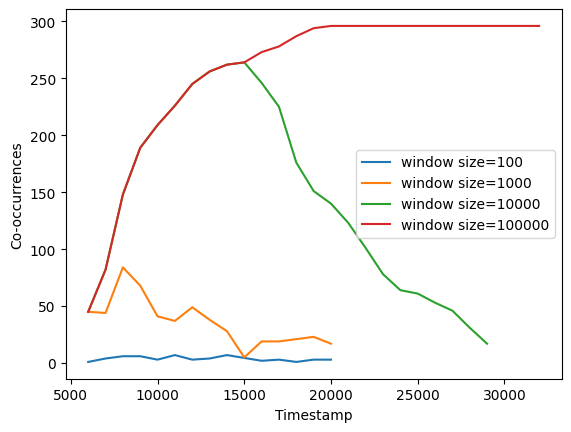

In [5]:
#Define our set of windows going up in orders of magnitude and our figure
windows = [100,1000,10000,100000]
fig, ax = plt.subplots()
ax.set_xlabel("Timestamp")
ax.set_ylabel("Co-occurrences")

#Run our query over a range from line 0 to 32000 with increments of 1000 sentences with two timefilters and our windows applied
df = lotr_graph \
      .starting_from(5000)\
      .to(20000)\
      .range(0,32000,1000) \
      .window(windows,Alignment.end())  \
      .execute(ctx.algorithms.generic.centrality.Degree()) \
      .to_df(["name","inDegree","outdegree","degree"]) 

#For each window plot out the co-occurrences
for window in windows:
    group_outdegree_and_plot(df[df['window']==window],ax,"window size="+str(window))

ax.legend()    

df.head(5)


# Dealing with timestamps and time scales

At this point you may be thinking "It is all well and good working with these logical epochs, but my data has real timestamps!" If so, let's take a quick detour away from our Lord of The Rings graph and have a look at another example which has some real world timestamps. 

Below we are downloading a second example dataset of users interacting on [Stack Exchange](https://stackexchange.com), the superclass of the Stack Overflow forum. In this network edges between users are created whenever anyone answers or comments on another users question, as described in the original data schema ([SNAP](https://snap.stanford.edu/data/sx-stackoverflow.html)).

We have stripped this down two three columns:

* The source of the interaction (the commenter)
* The destination of the interaction (the question asker)
* The time at which this interaction happened

In [6]:
!curl -o /tmp/stackex.csv https://raw.githubusercontent.com/Raphtory/Data/main/stackexchange.csv
print()
print("Source,Destination,Timestamp")
!head -n 3 /tmp/stackex.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5613k  100 5613k    0     0  11.4M      0 --:--:-- --:--:-- --:--:-- 11.4M

Source,Destination,Timestamp
1,2,2009-09-29 06:36:52
25,1,2009-09-29 15:00:04
14,16,2009-09-29 23:26:06


Ingesting this data works almost exactly the same as before, the only difference is that we will keep the `timestamp` as a String and must additionally provide a `time_format` which allows Raphtory to know how to convert the String into a DateTime object.

 We can see this below where the format for our data's timestamp is expressed as a regex. A cheat sheet for the different time elements these regex can express can be found [here](https://www.lukaszielinski.de/blog/posts/2015/02/10/date-to-string-and-string-to-date-in-java/). 

In [7]:
# create a new graph for the stack exchange data
timestamp_data_file = "/tmp/stackex.csv"
stack_exchange_graph = ctx.new_graph()

with open(timestamp_data_file, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:
      #Keep the timestamp in string format as it isn't just a simple integer
      timestamp = row[2]
      #Specify a format to allow Raphtory to parse the timestamps
      time_format= "yyyy-MM-dd HH:mm:ss"
      #extract the source/destination IDs as before
      source = int(row[0])
      destination = int(row[1])
      #Pass all of this information into an add_edge
      #We don't need an add vertex as we aren't giving the vertices any property or type information
      stack_exchange_graph.add_edge(timestamp,source,destination,time_format=time_format)

In [20]:
#Change the output format of the dataframe to datatime
#This means that the timestamp column will be a python date object instead of an integer
stack_exchange_graph = stack_exchange_graph.set_output_as_datetime()

df_cc = stack_exchange_graph \
    .at("2022-01-02")\
    .past() \
    .transform(ctx.algorithms.generic.ConnectedComponents) \
    .execute(ctx.algorithms.generic.NodeList(["cclabel"])) \
    .to_df(["name","cclabel"])

df_cc

01:07:44.553 [io-compute-blocker-14] ERROR s.c.c.c.c.QueryHandler - Deployment 'blue_orchid_whippet': Failed to handle message. class scala.collection.convert.JavaCollectionWrappers$JCollectionWrapper cannot be cast to class java.lang.String (scala.collection.convert.JavaCollectionWrappers$JCollectionWrapper is in unnamed module of loader 'app'; java.lang.String is in module java.base of loader 'bootstrap'). Skipping perspective.
java.lang.ClassCastException: class scala.collection.convert.JavaCollectionWrappers$JCollectionWrapper cannot be cast to class java.lang.String (scala.collection.convert.JavaCollectionWrappers$JCollectionWrapper is in unnamed module of loader 'app'; java.lang.String is in module java.base of loader 'bootstrap')
	at scala.collection.immutable.List.map(List.scala:246) ~[org.scala-lang.scala-library-2.13.10.jar:?]
	at scala.collection.immutable.List.map(List.scala:79) ~[org.scala-lang.scala-library-2.13.10.jar:?]
	at com.raphtory.api.analysis.algorithm.NodeListOu

,timestamp,name,cclabel


In [8]:
#Create a new list of windows, this time utilising real world increments
windows = ["1 day", "1 week", "1 month", "1 year"]

#
df_clustering = stack_exchange_graph \
    .walk("1 week") \
    .date_window(windows) \
    .execute(ctx.algorithms.generic.motif.GlobalClusteringCoefficient)\
    .to_df(["avgCluster", "globalCluster"])

df_clustering.tail()

,timestamp,window,avgCluster,globalCluster
27,2015-09-29 07:36:52,1 year,0.058174,0.0
28,2016-03-03 04:27:12,1 day,0.000000,0.0
29,2016-03-03 04:27:12,1 week,0.011324,0.0
30,2016-03-03 04:27:12,1 month,0.025300,0.0
31,2016-03-03 04:27:12,1 year,0.057196,0.0


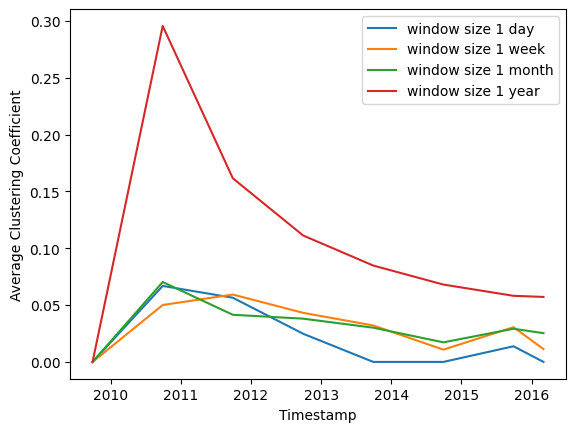

In [9]:
fig, ax = plt.subplots()
ax.set_xlabel("Timestamp")
ax.set_ylabel("Average Clustering Coefficient")

for window in windows:
    df_sub = df_clustering[df_clustering["window"] == window]
    ax.plot(df_sub["timestamp"], df_sub.avgCluster, label = "window size "+str(window))

ax.legend()
plt.show()

## Algorithmic Pipelines
_Returning to Middle Earth..._

Once we have defined the set of perspectives we want to work with, we may also want to define several algorithms to run across all of them. 

While the `.execute()` function returns a `Table`, graphs also have the function `transform()` which will apply an algorithm, but return the graph back with algorithmic state stored as a property. These can, therefore, be chained together to build as complex a pipeline as you like!

In addition to using already defined graph algorithms (as we have done so far), you can also apply operations directly to the graph object. This is especially useful when you want to pre-process the graph before applying an already defined algorithm.

To give an example of both of these elements, in the code below we:

* Create a set of perspectives via `depart` with two windows applied to each timepoint.
* Run both the PageRank and Connected Components algorithms. 
* Filter the graph for vertices with an out degree greater than 10.
* Execute the `NodeList` algorithm which takes a list of properties you which to return.
* Set the query running by requesting the dataframe.

Interestingly, we can see in the final result that before line 8000 the only character with which passes our filter is Frodo, and there are very few characters which make it in at all! Note, when filtering vertices, if a vertex is to be removed so will ALL of its edges. This means they will no longer be available to the vertex attached on the other side. 


In [10]:
cols = ["prlabel", "cclabel"]

df = lotr_graph\
    .depart(2000,1000) \
    .window([5000,10000]) \
    .transform(ctx.algorithms.generic.centrality.PageRank())\
    .transform(ctx.algorithms.generic.ConnectedComponents)\
    .vertex_filter(lambda vertex : vertex.out_degree() > 10)\
    .execute(ctx.algorithms.generic.NodeList(*cols)) \
    .to_df(["name"] + cols)

df.head(20)

,timestamp,window,name,prlabel,cclabel
0,4000,5000,Frodo,1.819291,-8483192681158692043
1,4000,10000,Frodo,1.819291,-8483192681158692043
2,5000,5000,Frodo,1.724370,-8483192681158692043
3,5000,10000,Frodo,1.724370,-8483192681158692043
4,6000,5000,Frodo,0.878061,-7470899208019142271
5,6000,10000,Frodo,1.415385,-8483192681158692043
6,7000,5000,Frodo,1.523748,-6692238662062972993
7,7000,10000,Frodo,1.612587,-8483192681158692043
8,8000,5000,Isildur,0.419222,-6692238662062972993
9,8000,5000,Frodo,1.848426,-6692238662062972993


## Saving your results to a Sink

To finish up we can look at the case where we want to either store our output for later use, or to push it downstream when Raphtory is being used as part of an ETL pipeline. To do this, instead of calling `to_df()`, we call `write_to(location)`, replacing location with where we want the data to be sent to. 

These locations are called `Sinks` and can be anything from files and databases to streaming platforms and other big data tools. Whilst some Sinks have domain specific formats others, such as `FileSinks`, are agnostic. As such we also provide standard `Formats` to output your data in e.g. csv and JSON. 

Calling `write_to()` will return a `ProgressTracker` which allows you to check the job ID, track which perspectives have been executed (along with how long they took) and wait for the job to fully complete.

An example of all of the elements can be seen in the code below where we:

* Define an algorithm pipeline and store this definition in a variable so it may be reused. 
* Execute the pipeline three times, writing out to the `FileSink`, specifying different file formats.
    * In the first instance we use the default format (`CSVFormat`).
    * In the second instance we specify the row-based JSON format where each line is a self contained JSON object.
    * In the third instance we use the global JSON format where the entire output from the job is one JSON object.
* Use the `ProgressTrackers` to wait for the jobs to complete, check how long the first perspective took and head the output of all three to compare.    



In [11]:
output_dir = "example_output"

#A function for heading the files we create
def head_file(filename,n):
    with open(output_dir+"/"+filename) as file:
        for x in range(n):
            print(next(file).strip())

#An example query based on the one in the last cell - this doesn't run yet as we haven't called .to_df() or .write_to()
pipeline = lotr_graph\
    .depart(2000,1000) \
    .past() \
    .transform(ctx.algorithms.generic.centrality.PageRank())\
    .transform(ctx.algorithms.generic.ConnectedComponents)\
    .vertex_filter(lambda vertex : vertex.out_degree() > 5)\
    .execute(ctx.algorithms.generic.NodeList(*cols))

#Running the above query by writing the output to different formats
tracker_csv = pipeline.write_to(FileSink(output_dir))
tracker_json_row = pipeline.write_to(FileSink(output_dir,JsonFormat.row_level()))
tracker_json_global = pipeline.write_to(FileSink(output_dir,JsonFormat.global_level()))

#Waiting for the queries to finishing writing so the output can be checked
tracker_csv.wait_for_job()
tracker_json_row.wait_for_job()
tracker_json_global.wait_for_job()

#Get information on the first perspective processed
first_perspective = tracker_csv.get_perspectives_processed()[0]
first_perspective_timestamp = first_perspective.timestamp()
first_perspective_time_taken = first_perspective.processing_time()

print("Perspective at timestamp "+str(first_perspective_timestamp)+" processed in "+str(first_perspective_time_taken)+"ms\n")


print("Output in CSV format:")
head_file(tracker_csv.get_job_id()+"/partition-0.csv",2)
print("\nOutput in JSON row format:")
head_file(tracker_json_row.get_job_id()+"/partition-0.json",2)
print("\nOutput in JSON global format:")
head_file(tracker_json_global.get_job_id()+"/partition-0.json",7)



Perspective at timestamp 2000 processed in 375ms

Output in CSV format:
2000,Frodo,1.5236035596330963,-8483192681158692043
2000,Peregrin,0.6576462226811949,-8483192681158692043

Output in JSON row format:
{"timestamp":2000,"row":["Frodo",1.5236035596330963,-8483192681158692043]}
{"timestamp":2000,"row":["Peregrin",0.6576462226811949,-8483192681158692043]}

Output in JSON global format:
{
"jobID" : "PageRank:ConnectedComponents:NodeList_2158746593669455057",
"partitionID" : 0,
"perspectives" : [ {
"timestamp" : 2000,
"rows" : [ [ "Frodo", 1.5236035596330963, -8483192681158692043 ], [ "Peregrin", 0.6576462226811949, -8483192681158692043 ] ]
}, {


### Whats Next
You should now be equipt to do some exciting analysis within Raphtory using the variety of built in Algorithms. However, if you want to look at how to build your own algorithms for your own use or to submit to the general library, please continue on to the next page. 